# SIIM-ISIC Melanoma Classification
## Binary Classification Projektarbeit vom 22.05. bis 06.06.2023 ~ Liam Wander

- Erstellen Sie eine kurze explorative Datenanalyse zur train.csv um erste Einsichten zu gewinnen. Auffälligkeiten bitte in kurzer Form im Markdown notieren.
- Erstellen Sie ein Pytorch-Dataset, in dem Sie die Bilder und tabularen Daten zusammenfassen. Das Dataset wird drei(!) Dinge zurückgeben (das Bild, die passende Zeile aus dem Dataframe sowie das Target)
- Erstellen Sie ein Pytorch-Modell, welches ausschließlich aufgrund der Bilder klassifiziert.
- Testen Sie das Modell mit einem Sample
- Trainieren Sie das Modell und geben Sie die Accuracy sowie den F1-Score aus
- Kombinieren Sie nun tabulare Daten und Bilder: Erstellen Sie ein weiteres Pytorch-Modell welches das Bild UND die tabularen Daten verarbeiten kann. (Tipp: die Forward-Methode bekommt hier das Bild sowie die passende Zeile aus dem Dataframe übergeben, es handelt sich hier um ein Multimodales-Modell)
- Halten Sie ihr Vorgehen in Form eines (kurzen, gerne auch stichwortartigen) Protokolls im Markdown fest. Gehen Sie auch auf Probleme und Sackgassen ein!
- Beide Modelle sollen eine submission erstellen!

Tipps:

- Da hier einiges neu ist (multimodales Modell z.B.): nutzen Sie copilot, chatgpt und das Internet um herauszufinden, wie Sie das Problem angehen. 
- Das Dataset ist unbalanced, das ist ein Problem welches Sie lösen müssen
- EfficientNet dürfen auch benutzt werden, sie sind kleiner und leistungsfähiger als resnets → https://pytorch.org/hub/nvidia_deeplearningexamples_efficientnet/

https://www.statology.org/label-encoding-vs-one-hot-encoding/ OHE statt LabelEncoding, da LE eine scheinbare Gewichtung erzeugt

https://www.statology.org/dummy-variable-trap/

In [1]:
!pip install validators matplotlib
!pip install pytorch-lightning
!pip install efficientnet_pytorch
!pip install ipywidgets

  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=3f69e36eb75276abad04771f645bb43c33a572e93d3bf2a53a2e38c315e17731
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=349afbb9025321d4215b42ceeeee59957ce8bc991523c2ac50591d9c68bd665e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch, os, torchvision
from PIL import Image
import torchvision.transforms as transforms
import json
import requests
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from efficientnet_pytorch import EfficientNet


import torch.nn as nn
from torch.nn import functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.utils import resample # resampling unbalanced data


train_image_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train'
test_image_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device}')


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using cuda


## Datenaufbereitung und Explorative Datenanalyse via ```train.csv```

In [3]:
train_data = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test_data = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')

In [4]:
train_data[:5]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
test_data[:5]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


train.csv enthält mehrere NaN-Werte in den Attributen sex, age_approx und anatom_site_general_challenge

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [8]:
train_data['sex'].unique()

array(['male', 'female', nan], dtype=object)

In [9]:
train_data['age_approx'].unique()

array([45., 50., 55., 40., 25., 35., 30., 75., 70., 65., 60., nan, 80.,
       20., 85., 15., 90., 10.,  0.])

In [10]:
train_data['age_approx'].describe()

count    33058.000000
mean        48.870016
std         14.380360
min          0.000000
25%         40.000000
50%         50.000000
75%         60.000000
max         90.000000
Name: age_approx, dtype: float64

Die NaN Werte des numerischen Tupels ```age_approx``` werden aufgrund der Extremen mit dem Median ersetzt (50%=50)

In [11]:
train_data['age_approx'].fillna(50,inplace = True)

In [12]:
train_data.iloc[:,4].unique()

array(['head/neck', 'upper extremity', 'lower extremity', 'torso', nan,
       'palms/soles', 'oral/genital'], dtype=object)

In [13]:
train_data.iloc[:,4].fillna('unknown', inplace = True)
test_data.iloc[:,4].fillna('unknown', inplace = True)

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33126 non-null  float64
 4   anatom_site_general_challenge  33126 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


<AxesSubplot: >

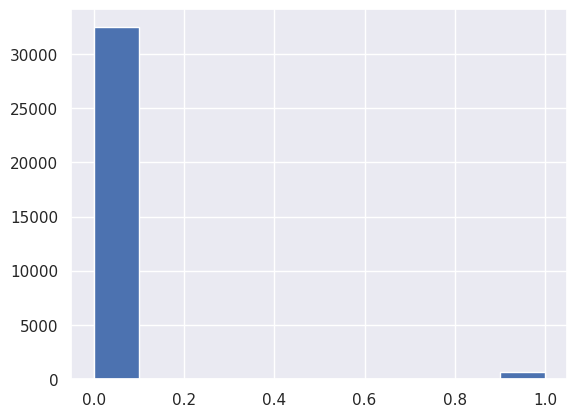

In [15]:
train_data['target'].hist()

-> Bewahrheitete Erkenntnis: moderat unausgeglichene Daten unter ```target``` im Datensatz!

Möglichkeiten zur "Korrektur":
- Nutzung anderer Performance Indikatoren
- Resampling und gewichten
    - 1. Downsampling: das Training mit einer unverhältnismäßig kleinen Teilmenge der Beispiele aus der Mehrheitsklasse.
    - 2. Bei der Gewichtung wird der Downsampling-Klasse eine Beispielgewichtung hinzugefügt, die dem Faktor entspricht, um den das Downsampling durchgeführt wurde
- Synthetische Datensätze in der Minderklasse bereitstellen

### Kategorische Daten über OHE einer Klasse zuweisen und target=0 downsamplen sowie gewichten

Die einzelnen Tupel sind nicht numerisch, sondern als Object gespeichert. Damit diese im weiteren Vorgehen analysierbar und verwertbar sind, bedarf es eines Label Encodings. Sprich als nächsten Schritt gilt es gleiche Objekte einer Klasse zuzuweisen.

In [16]:
df_majority = train_data[train_data['target'] == 0] # benign
df_minority = train_data[train_data['target'] == 1] # malign

In [17]:
len(df_minority)/len(df_majority)*100

1.7946038965029807

Die maligne Klasse ist nur 1,8% so groß wie die benigne Klasse, demnach ist das Trainings-Datenset mäßig unausgeglichen. Das wird geändert indem zufällig die Klasse benign um den Faktor 20 gekürzt wird. 

In [18]:
# downsample majority class
df_downsampled = resample(df_majority,
             replace=True,
             n_samples=int(len(df_majority)/20), # -95%
             random_state=42)

print(df_downsampled.shape)

(1627, 8)


In [19]:
# Display new class counts
df_downsampled.target.value_counts()
df_downsampled['target'].value_counts()
df_downsampled['target'].value_counts(normalize=True)

0    1.0
Name: target, dtype: float64

In [20]:
# combine minority class with downsampled majority class
df_downsampled = pd.concat([df_downsampled, df_minority])
df_downsampled = df_downsampled.sample(frac=1).reset_index(drop=True) # random shuffle


In [21]:
# example_weight = original_example_weight * downsampling_factor
#class_weight = (df_majority / len(df_majority)+len(df_minority)) / (int( len(df_majority)) / int( len(df_majority)+len(df_minority) ))
df_downsampled['weight']=np.where(df_downsampled['target']==1,(len(df_majority)/len(train_data)) / (len(df_minority) / len(df_minority) *2), (len(df_minority) / len(train_data)) / (len(df_minority) / len(df_minority) *2))


<AxesSubplot: >

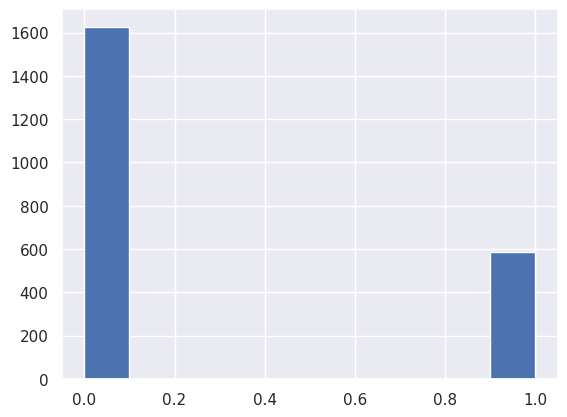

In [22]:
df_downsampled['target'].hist()

In [23]:
df_downsampled.shape

(2211, 9)

### Warum Downsampling und Gewichtung?
Es mag seltsam erscheinen, nach  Sampling Stichprobengewichtungen hinzuzufügen. Wir haben versucht, unser Modell für die Minderheitenklasse zu verbessern. Warum sollten wir die Mehrheit höher gewichten? Das sind die Änderungen:

- Schnellere Konvergenz: Während des Trainings sehen wir die Minderheitsklasse häufiger, wodurch das Modell schneller konvergiert wird.
- Laufwerksspeicher: Wenn Sie die Mehrheitsklasse in weniger Beispielen mit größerer Gewichtung konsolidieren, sparen wir weniger Speicherplatz. Diese Einsparungen ermöglichen mehr Speicherplatz für die Minderheitsklasse, sodass wir eine größere Anzahl und eine größere Auswahl an Beispielen aus dieser Klasse erfassen können.
- Kalibrierung: Durch die Gewichtung erfolgt die Kalibrierung unseres Modells. Die Ausgaben können trotzdem als Wahrscheinlichkeiten interpretiert werden.

```
import torch

x = torch.rand(8, 4)
# Ground truth
y = torch.randint(2, (8,))
# Weights per sample 
weights = torch.rand(8, 1) 

# Add weights as a columns, so that it will be passed trough
# dataloaders in case you want to use one
x = torch.cat((x, weights), dim=1)

model = torch.nn.Linear(4, 2)

loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
def weighted_loss(y, y_hat, w):
  return (loss_fn(y, y_hat)*w).mean()

loss = weighted_loss(model(x[:, :-1]), y, x[:, -1])
print (loss)
```

In [24]:
# replace one sex entry in test_data with NaN to be able to perform one hot encoding hastily
test_data['sex'][0] = np.nan

In [25]:
from sklearn.preprocessing import OneHotEncoder
categorical = ['sex', 'anatom_site_general_challenge']
cat_to_be_deleted = ['diagnosis', 'benign_malignant'] # sind nicht realistisch in test daten vorhanden! -> schwierig damit ein Netz zu trainieren, es sei denn man will 3 Targets haben
categorical_cols_train = []
categorical_cols_test = []

for col in categorical:
    categorical_cols_train += [f"{col[0]}_{val}" for val in train_data[col].unique()]
    
for col in categorical:
    categorical_cols_test += [f"{col[0]}_{val}" for val in test_data[col].unique()]

print(categorical_cols_train)
print(categorical_cols_test)
# create the encoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# fit and transform the categorical variables.
final_train = pd.DataFrame(encoder.fit_transform(df_downsampled[categorical]),
                          index=df_downsampled.index, columns=categorical_cols_train)

final_train['target'] = df_downsampled['target'] # Needed to create the correct ImageTargetDataset!
final_train.insert(0, 'image_name', df_downsampled['image_name'])
final_train.insert(1, 'patient_id', df_downsampled['patient_id'])

final_test = pd.DataFrame(encoder.transform(test_data[categorical]),
                            index=test_data.index, columns=categorical_cols_train)
final_test.insert(0, 'image_name', test_data['image_name'])
final_test.insert(1, 'patient_id', test_data['patient_id'])

print(final_train) # using df_downsampled instead of train_data
print(final_test)

['s_male', 's_female', 's_nan', 'a_head/neck', 'a_upper extremity', 'a_lower extremity', 'a_torso', 'a_unknown', 'a_palms/soles', 'a_oral/genital']
['s_nan', 's_male', 's_female', 'a_unknown', 'a_lower extremity', 'a_torso', 'a_upper extremity', 'a_head/neck', 'a_palms/soles', 'a_oral/genital']
        image_name  patient_id  s_male  s_female  s_nan  a_head/neck  \
0     ISIC_3097354  IP_4070933     0.0       1.0    0.0          0.0   
1     ISIC_3003111  IP_5109559     0.0       1.0    0.0          0.0   
2     ISIC_5031380  IP_6292705     0.0       1.0    0.0          1.0   
3     ISIC_4282634  IP_1197949     0.0       1.0    0.0          0.0   
4     ISIC_0779920  IP_9663529     1.0       0.0    0.0          0.0   
...            ...         ...     ...       ...    ...          ...   
2206  ISIC_2592956  IP_3089004     1.0       0.0    0.0          0.0   
2207  ISIC_5889165  IP_3402498     0.0       1.0    0.0          0.0   
2208  ISIC_5021861  IP_0718832     1.0       0.0    0.0 

Nun haben wir zwei Binärkodierte Datensätze, die vielleicht mehr in einer kurzen explorativen Datenanalyse aussagen können.
EDIT vom 01.06.: Das Dataset setzt sich nun aus dem df_downsampled (2200 entries) statt den train_data (33000 entries) zusammen!
macht das Training um einiges schneller

<AxesSubplot: >

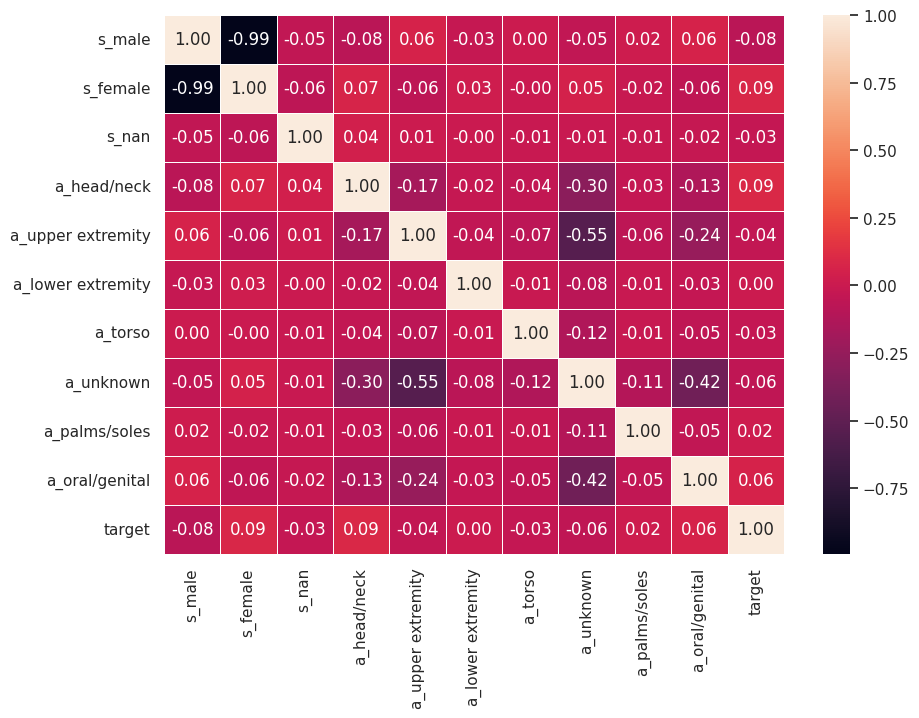

In [26]:
corr = final_train.corr()
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5)

Der Körperbereich "unbekannt" korrelliert mäßig negativ mit dem Körperbereich der Oberen Extremität -> Letzteres, genauso wie der Genitalbereich scheint am häufigsten vorzukommen - bzw. wo unerwünschte Hautveränderungen bemerkt werden(?)
Außerdem: Wer kein Mann ist, ist eine Frau - und vice versa.

## Creating a DataSet that contains the Images, Data Entries and Targets
Constructing own Python Dataset, which inherits most of its features from the module Dataset:

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 10]) torch.Size([4])


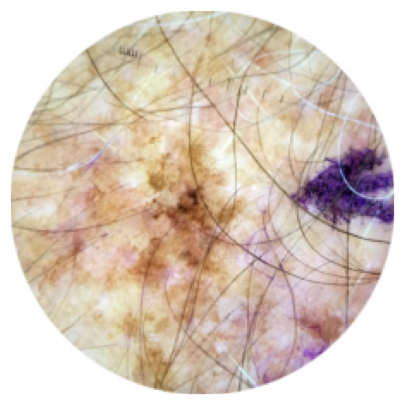

tabular_data: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1.])
target: 1


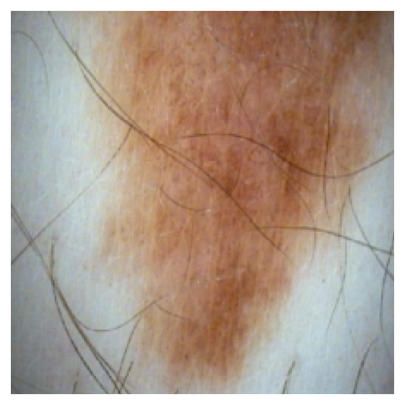

tabular_data: tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0.])
target: 0


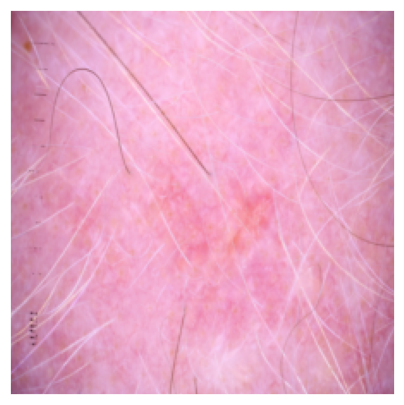

tabular_data: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
target: 0


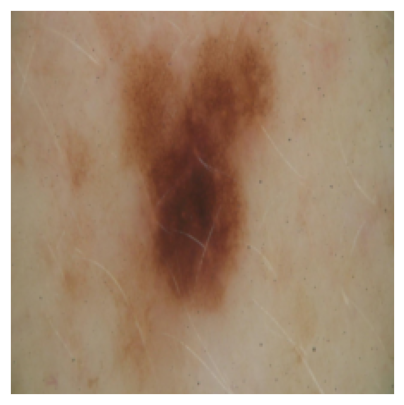

tabular_data: tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0.])
target: 0


In [27]:
class ImageTargetDataset(Dataset):
    '''Image, Tabular and Target dataset.'''
    def __init__(self, dataframe, image_dir, transform=None):
        self.tabular_data = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.tabular_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        
        tabular_data = self.tabular_data.iloc[idx, 0:]

        y = tabular_data['target']

        image = Image.open(f"{self.image_dir}/{tabular_data['image_name']}.jpg")
        image = image.convert('RGB')
        #image = np.array(image)
        #image = image[..., :3]
        
        if self.transform:
            image = self.transform(image)
                
        #image = transforms.functional.to_tensor(image)

        tabular_data = tabular_data[['s_male', 's_female', 's_nan', 'a_head/neck', 'a_upper extremity', 'a_lower extremity', 'a_torso', 'a_unknown', 'a_palms/soles', 'a_oral/genital']]
        tabular_data = tabular_data.tolist()
        tabular_data = torch.FloatTensor(tabular_data)
        return image, tabular_data, y
    
transform=torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True) # suited for EfficientNetB0
])


sample = ImageTargetDataset(final_train, train_image_path, transform=transform)
sample_loader = DataLoader(sample, batch_size=4, shuffle=True, num_workers=4)

for i, (image, tabular_data, y) in enumerate(sample_loader):
    print(i, image.shape, tabular_data.shape, y.shape)
    if i == 0:
        break
        
# visualize some images
def show(imgs, figsize=(10,10), *args, **kwargs):
    '''Visualize tensors as images.'''
    grid_imgs = torchvision.utils.make_grid(imgs, *args, **kwargs)
    plt.figure(figsize=figsize)
    plt.imshow(grid_imgs.permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.show()

for i in range(4):
    image, tabular_data, y = sample[i]
    show(image, title=f"image {i}", figsize=(5,5))
    print(f"tabular_data: {tabular_data}")
    print(f"target: {y}")

Abschließend liegt ein 3-dimensionaler Datensatz vor, welcher uns je ein Bild, das dazugehörige Datum im Binärformat und das Target zurückgibt.

## Creating a PyTorch Model that classifies the Target based solely on the images
Später vielleicht mit PyTorch Lightning vergleichen? 

https://lightning.ai/docs/pytorch/stable/model/train_model_basic.html

https://lightning.ai/docs/pytorch/latest/

In [28]:
# PyTorch Lightning
# define the EfficentNet model for the image data
class EfficientNetModel(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-4):
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        # images are RGB, so 3 channels and the size is 224x224
        self.model._conv_stem = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.model._fc = nn.Linear(in_features=1280, out_features=num_classes, bias=True)
        self.lr = lr

    def forward(self, image):
        out = self.model(image).to(device)
        return out
    
    def cross_entropy_loss(self, logits, labels):
        loss = nn.CrossEntropyLoss().to(device)
        return loss(logits, labels)
    
    def training_step(self, train_batch, batch_idx):
        image, _, target = train_batch #returns image, tabular_data, target
        logits = self.forward(image).to(device)
        loss = self.cross_entropy_loss(logits, target.unsqueeze(1).float())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        image, _,target = batch
        logits = self.forward(image).to(device)
        loss = self.cross_entropy_loss(logits, target.unsqueeze(1).float())
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

transform=torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True)
])

In [29]:

X_train, X_test, y_train, y_test = train_test_split(final_train, final_train['target'], test_size=0.2, random_state=42)

train_dataset = ImageTargetDataset(X_train, train_image_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

test_dataset = ImageTargetDataset(X_test, train_image_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Training with GPU P100, since this GPU is better suited for training image data.

In [30]:
model = EfficientNetModel(num_classes=1, lr=1e-4).to(device)

trainer = pl.Trainer(max_epochs=1)
trainer.fit(model, train_loader, test_loader)
with torch.no_grad():
    model.eval()
    y_pred = []
    for image, tabular_data, _ in test_loader:
        image = image.to(device)
        tabular_data = tabular_data.to(device)
        logits = model(image).to(device)
        y_hat = logits.argmax(1)
        y_pred.append(y_hat.cpu().numpy())
    y_pred = np.concatenate(y_pred)
    print(y_pred)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(f"AUC: {roc_auc_score(y_test, y_pred)}")

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver operating characteristic example', fontsize=15)
plt.legend(loc="lower right")
plt.show()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 77.7MB/s]


Loaded pretrained weights for efficientnet-b0


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

Nachdem der Datensatz von test_data (33000E) zu df_downsampled (2200E) gewechselt wurde, geht das Training deutlich schneller als ~4h für eine Epoche. Nun dauert eine Epoche nur etwa 10 Minuten, und die maximale Anzahl dieser wurde von 3 auf 10 hochgesetzt.

In [ ]:
# plot loss
plt.figure(figsize=(5, 5))
plt.plot(trainer.history['train_loss'], label='train_loss')
plt.plot(trainer.history['val_loss'], label='val_loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Loss vs. Epochs', fontsize=15)
plt.legend(loc="upper right")
plt.show()

# plot accuracy
plt.figure(figsize=(5, 5))
plt.plot(trainer.history['train_acc'], label='train_acc')
plt.plot(trainer.history['val_acc'], label='val_acc')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy vs. Epochs', fontsize=15)
plt.legend(loc="lower right")
plt.show()

# plot precision
plt.figure(figsize=(5, 5))
plt.plot(trainer.history['train_precision'], label='train_precision')
plt.plot(trainer.history['val_precision'], label='val_precision')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.title('Precision vs. Epochs', fontsize=15)
plt.legend(loc="lower right")
plt.show()

# plot recall
plt.figure(figsize=(5, 5))
plt.plot(trainer.history['train_recall'], label='train_recall')
plt.plot(trainer.history['val_recall'], label='val_recall')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Recall', fontsize=15)
plt.title('Recall vs. Epochs', fontsize=15)
plt.legend(loc="lower right")
plt.show()

# plot f1
plt.figure(figsize=(5, 5))
plt.plot(trainer.history['train_f1'], label='train_f1')
plt.plot(trainer.history['val_f1'], label='val_f1')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('F1', fontsize=15)
plt.title('F1 vs. Epochs', fontsize=15)
plt.legend(loc="lower right")
plt.show()

# plot auc
plt.figure(figsize=(5, 5))
plt.plot(trainer.history['train_auc'], label='train_auc')
plt.plot(trainer.history['val_auc'], label='val_auc')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('AUC', fontsize=15)
plt.title('AUC vs. Epochs', fontsize=15)
plt.legend(loc="lower right")
plt.show()

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, y_pred))
plt.title(all_sample_title, size = 15);

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver operating characteristic example', fontsize=15)
plt.legend(loc="lower right")
plt.show()

# visualize some images
def show(imgs, figsize=(10,10), *args, **kwargs):
    '''Visualize tensors as images.'''
    grid_imgs = torchvision.utils.make_grid(imgs, *args, **kwargs)
    plt.figure(figsize=figsize)
    plt.imshow(grid_imgs.permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.show()

for i in range(4):
    image, tabular_data, y = sample[i]
    show(image, title=f"image {i}", figsize=(5,5))
    print(f"tabular_data: {tabular_data}")
    print(f"target: {y}")

ETA 4 hours per epoch. https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [ ]:
# use multiprocessing to speed up training (?)
# regarding
from multiprocessing import Pool
from tqdm import tqdm

def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        for image, tabular_data, target in tqdm(train_loader):
            image = image.to(device)
            tabular_data = tabular_data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            logits = model(image)
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for image, tabular_data, target in test_loader:
                image = image.to(device)
                tabular_data = tabular_data.to(device)
                target = target.to(device)
                logits = model(image)
                _, predicted = torch.max(logits.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            print(f"Epoch {epoch+1}/{epochs}: Test accuracy: {correct/total}")

model = EfficientNetModel(num_classes=1, lr=1e-3)
train_model(model, train_loader, test_loader, epochs=10, lr=1e-3)

# use multiprocessing to speed up training

In [ ]:
# predict image on test_dataset
with torch.no_grad():
    logits = model(torch.stack([test_dataset[i][0] for i in range(len(test_dataset))]).to(device))
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    print(preds)

In [ ]:
# torch no grad
with torch.no_grad():
    for image, tabular_data, y in val_dataloader:
        out = model(image)
        out = torch.sigmoid(out)
        preds.append(out.detach().cpu().numpy())

In [ ]:
train_dataloader = DataLoader(
    ImageTargetDataset(final_train, train_image_path, transform=transform),
    batch_size=32, shuffle=True, num_workers=4
)

model = EfficientNetModel(num_classes=1, lr=1e-4)
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, train_dataloader)

# predict on test set
preds = []
for image, tabular_data, y in test_dataloader:
    out = model(image)
    out = torch.sigmoid(out)
    preds.append(out.detach().cpu().numpy())
preds = np.concatenate(preds)
print(preds.shape)

## Creating a PyTorch (Lightning) model that classifies the Targets based on Images and Tabular Data

In [ ]:
# PyTorch Lightning
# define the EfficentNet model for the image and tabular data
class EfficientNetModel(pl.LightningModule):
    '''PyTorch Lightning module for the EfficientNet model, for a binary classification problem.'''
    '''Learning from Images and Tabular Data.'''
    def __init__(self, num_classes, lr=1e-4):
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        # images are RGB, so 3 channels and the size is 224x224
        self.model._conv_stem = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False) # 3 
        self.model._fc = nn.Linear(in_features=1280, out_features=num_classes, bias=True) 
        self.lr = lr
        self.tabular_model = nn.Sequential( 
            nn.Linear(10, 64), # 10 = number of tabular features
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, image, tabular_data):
        out = self.model(image) # pass the image through the EfficientNet model
        out = out.view(out.size(0), -1) # flatten the output of the convolutional layers
        out = self.tabular_model(tabular_data) # pass the tabular data through the tabular model
        return out
    
    def cross_entropy_loss(self, logits, labels):
        loss = nn.CrossEntropyLoss()
        return loss(logits, labels)
    
    def training_step(self, train_batch, batch_idx):
        image, tabular_data, y = train_batch
        logits = self.forward(image, tabular_data)
        loss = self.cross_entropy_loss(logits, y.unsqueeze(1).float())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        image, tabular_data, y = batch
        logits = self.forward(image, tabular_data)
        loss = self.cross_entropy_loss(logits, y.unsqueeze(1).float())
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
transform=torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True)
])

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

X_train, X_test, y_train, y_test = train_test_split(final_train, final_train['target'], test_size=0.2, random_state=42)

train_dataset = ImageTargetDataset(X_train, train_image_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

test_dataset = ImageTargetDataset(X_test, train_image_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

model = EfficientNetModel(num_classes=1, lr=1e-4).to(device)

trainer = pl.Trainer(max_epochs=10, gpus=1)
trainer.fit(model, train_loader, test_loader)

In [ ]:
# predict
def predict(model, test_loader):
    model.eval()
    preds = []
    for image, tabular_data, _ in test_loader:
        image = image.to(device)
        tabular_data = tabular_data.to(device)
        with torch.no_grad():
            logits = model(image, tabular_data)
            logits = logits.squeeze(1)
            preds.append(logits.sigmoid().detach().cpu().numpy())
    preds = np.concatenate(preds)
    return preds

preds = predict(model, test_loader)

preds

In [ ]:
# visualise some images
def show(imgs, figsize=(10,10), *args, **kwargs):
    '''Visualize tensors as images.'''
    grid_imgs = torchvision.utils.make_grid(imgs, *args, **kwargs)
    plt.figure(figsize=figsize)
    plt.imshow(grid_imgs.permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.show()

for i in range(4):
    image, tabular_data, y = sample[i]
    show(image, title=f"image {i}", figsize=(5,5))
    print(f"tabular_data: {tabular_data}")
    print(f"target: {y}")